## Resources
https://www.tensorflow.org/tutorials/audio/simple_audio


https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/speech_commands

In [4]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [5]:
# data_dir = pathlib.Path('data/data_speech_commands_v0.02') ## Full dataset
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')


182083584/182082353 [==============================] - 22s 0us/step


In [6]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['right' 'go' 'no' 'left' 'stop' 'up' 'down' 'yes']


In [9]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/no/18a8f03f_nohash_1.wav', shape=(), dtype=string)


In [16]:

train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

train_size = len(train_files)
val_size = len(val_files)
test_size = len(test_files)

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

assert train_size + val_size + test_size == num_samples,"are u sure u dont want to use the full dataset"


Training set size 6400
Validation set size 800
Test set size 800


In [29]:
def decode_audio(audio_binary):
    
    '''converts wav to tensor'''
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
    return parts[-2]

def get_waveform_and_label(file_path):
    
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [35]:
print(train_files)
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
print(waveform_ds)

tf.Tensor(
[b'data/mini_speech_commands/no/18a8f03f_nohash_1.wav'
 b'data/mini_speech_commands/stop/6f689791_nohash_2.wav'
 b'data/mini_speech_commands/stop/327289eb_nohash_1.wav' ...
 b'data/mini_speech_commands/right/34ba417a_nohash_2.wav'
 b'data/mini_speech_commands/yes/db72a474_nohash_0.wav'
 b'data/mini_speech_commands/down/3ae5c04f_nohash_0.wav'], shape=(6400,), dtype=string)
<ParallelMapDataset shapes: ((None,), ()), types: (tf.float32, tf.string)>


0.5

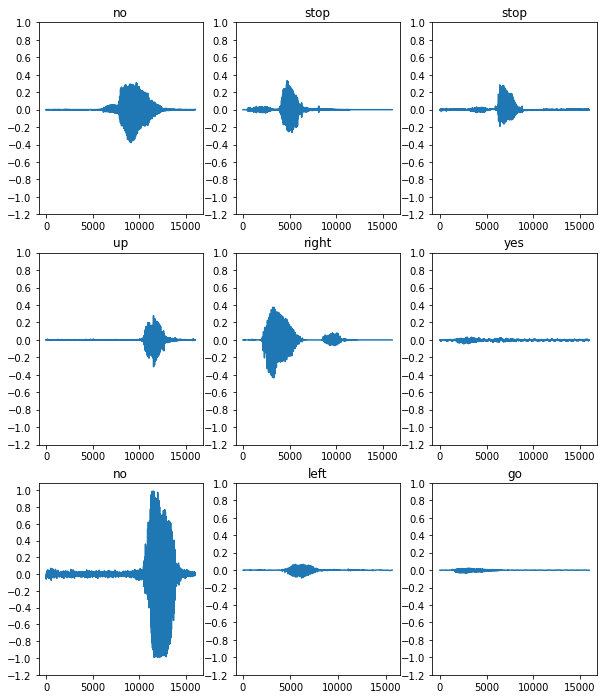

In [34]:
rows = 3
cols = 3

n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)
plt.show()

Spectrogram
You'll convert the waveform into a spectrogram, which shows frequency changes over time and can be represented as a 2D image. This can be done by applying the short-time Fourier transform (STFT) to convert the audio into the time-frequency domain.

A Fourier transform (tf.signal.fft) converts a signal to its component frequencies, but loses all time information. The STFT (tf.signal.stft) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

STFT produces an array of complex numbers representing magnitude and phase. However, you'll only need the magnitude for this tutorial, which can be derived by applying tf.abs on the output of tf.signal.stft.

Choose frame_length and frame_step parameters such that the generated spectrogram "image" is almost square. For more information on STFT parameters choice, you can refer to this video on audio signal processing.

https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe

Time-Frequency compromise in the STFT: if the window samples are small we get a good time resolution and a bad freq res. Bigger window size we get a better freq res, but not so good time resolution.

You also want the waveforms to have the same length, so that when you convert it to a spectrogram image, the results will have similar dimensions. This can be done by simply zero padding the audio clips that are shorter than one second.

In [48]:
def get_spectrogram(waveform):
    # to ensure consitancy we padd files that have less than 16k samples
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
    
    # concatenate audio with padding to ensure same length for all files
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram) # we only take the amplitude and discard the phase
    return spectrogram

In [56]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)
    
print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


<ipython-input-57-bf604f63e346>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X,Y,log_spectrogram)


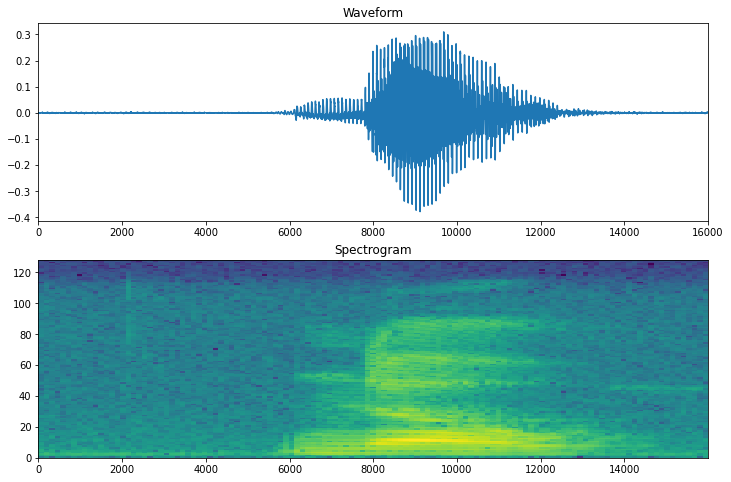

In [57]:
def plot_spectrogram(spectrogram, ax):
# Convert spectrogram to log scale and transpose so that the time is
  # represented in the x-axis (columns).
    log_spectrogram = np.log(spectrogram.T)
    height = log_spectrogram.shape[0]
    width = log_spectrogram.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X,Y,log_spectrogram)
    
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [59]:
# now we will get a dataset where the feature is the spectrogram, 
# and the label as an integer id so our dataset will have sampels
# like this (spectrogram, label_id)
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram , -1)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

Tensor("Equal_1:0", shape=(8,), dtype=bool)


<ipython-input-57-bf604f63e346>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X,Y,log_spectrogram)
<ipython-input-57-bf604f63e346>:4: RuntimeWarning: divide by zero encountered in log
  log_spectrogram = np.log(spectrogram.T)


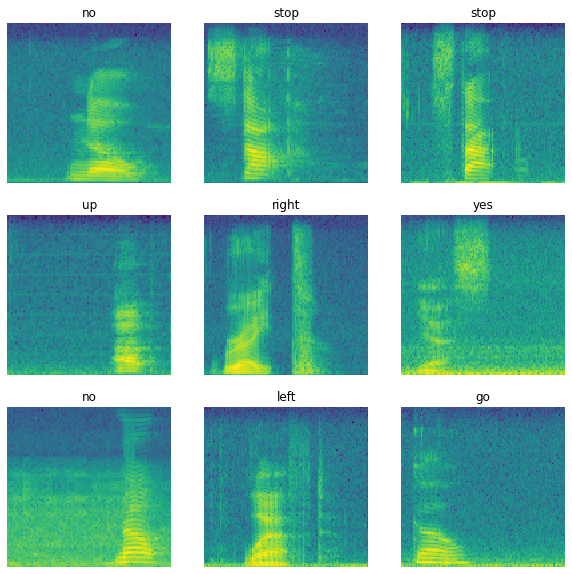

In [71]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [72]:
def preprocess_dataset(files):
    
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(
        get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
    return output_ds

train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Tensor("Equal_1:0", shape=(8,), dtype=bool)
Tensor("Equal_1:0", shape=(8,), dtype=bool)


In [73]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [75]:
# prefetch and cache reduce reading latency when training the model
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [77]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)


Input shape: (124, 129, 1)


For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images. The model also has the following additional preprocessing layers:

A Resizing layer to downsample the input to enable the model to train faster.
A Normalization layer to normalize each pixel in the image based on its mean and standard deviation.
For the Normalization layer, its adapt method would first need to be called on the training data in order to compute aggregate statistics (i.e. mean and standard deviation).

In [78]:
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [79]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [80]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 8s 78ms/step - loss: 1.7037 - accuracy: 0.3814 - val_loss: 1.2945 - val_accuracy: 0.5750
Epoch 2/10
100/100 [==============================] - 6s 57ms/step - loss: 1.1191 - accuracy: 0.6030 - val_loss: 0.9393 - val_accuracy: 0.6862
Epoch 3/10
100/100 [==============================] - 6s 62ms/step - loss: 0.8558 - accuracy: 0.6903 - val_loss: 0.7908 - val_accuracy: 0.7387
Epoch 4/10
100/100 [==============================] - 8s 78ms/step - loss: 0.6887 - accuracy: 0.7581 - val_loss: 0.7110 - val_accuracy: 0.7775
Epoch 5/10
100/100 [==============================] - 7s 67ms/step - loss: 0.5984 - accuracy: 0.7894 - val_loss: 0.6882 - val_accuracy: 0.7750
Epoch 6/10
100/100 [==============================] - 7s 72ms/step - loss: 0.5121 - accuracy: 0.8152 - val_loss: 0.6401 - val_accuracy: 0.8012
Epoch 7/10
100/100 [==============================] - 6s 65ms/step - loss: 0.4747 - accuracy: 0.8383 - val_loss: 0.6144 - val_accuracy: 0.8037

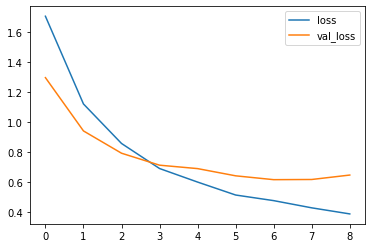

In [81]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [83]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [84]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 80%


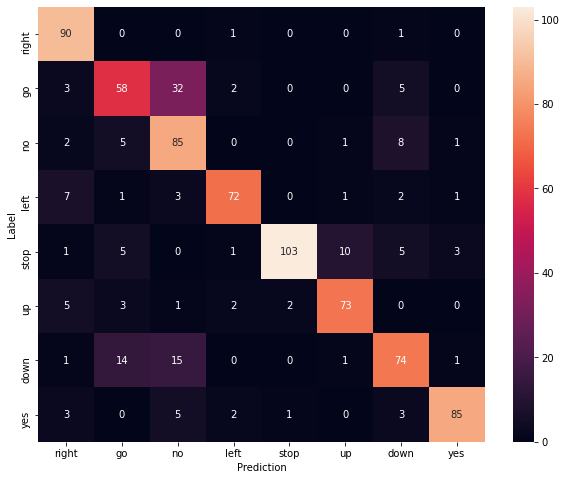

In [85]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Tensor("Equal_1:0", shape=(8,), dtype=bool)


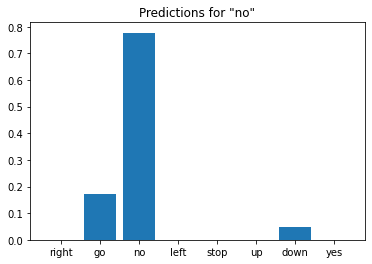

In [86]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()